## Machine Learning model with Apache Spark MLlib


#### Documentation https://docs.microsoft.com/en-us/azure/


## 3. Data loading and preprocessing


In [2]:
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil import parser
from pyspark.sql.functions import unix_timestamp, date_format, col, when
from pyspark.ml import Pipeline
from pyspark.ml import PipelineModel
from pyspark.ml.feature import RFormula
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator

StatementMeta(NEWPOOL, 3, 2, Finished, Available)

### Task. Import the datetime library and matplotlib.pyplot as plt 


In [19]:
from datetime import datetime
import matplotlib.pyplot as plt

StatementMeta(NEWPOOL, 3, 19, Finished, Available)

#### Build the input Dataframe


In [3]:
from azureml.opendatasets import NycTlcYellow

end_date = parser.parse('2018-06-06')
start_date = parser.parse('2018-05-01')
nyc_tlc = NycTlcYellow(start_date=start_date, end_date=end_date)
filtered_df = nyc_tlc.to_spark_dataframe()

StatementMeta(NEWPOOL, 3, 3, Finished, Available)

In [4]:
# To make development easier, faster and less expensive down sample for now
sampled_taxi_df = filtered_df.sample(True, 0.001, seed=1234)

StatementMeta(NEWPOOL, 3, 4, Finished, Available)

In [5]:
#sampled_taxi_df.show(5)
display(sampled_taxi_df)

StatementMeta(NEWPOOL, 3, 5, Finished, Available)

SynapseWidget(Synapse.DataFrame, 9db38fd5-15f0-4401-b543-77e02b0bdafc)

#### Prepare data


In [6]:
taxi_df = sampled_taxi_df.select('totalAmount', 'fareAmount', 'tipAmount', 'paymentType', 'rateCodeId', 'passengerCount'\
                                , 'tripDistance', 'tpepPickupDateTime', 'tpepDropoffDateTime'\
                                , date_format('tpepPickupDateTime', 'hh').alias('pickupHour')\
                                , date_format('tpepPickupDateTime', 'EEEE').alias('weekdayString')\
                                , (unix_timestamp(col('tpepDropoffDateTime')) - unix_timestamp(col('tpepPickupDateTime'))).alias('tripTimeSecs')\
                                , (when(col('tipAmount') > 0, 1).otherwise(0)).alias('tipped')
                                )\
                        .filter((sampled_taxi_df.passengerCount > 0) & (sampled_taxi_df.passengerCount < 8)\
                                & (sampled_taxi_df.tipAmount >= 0) & (sampled_taxi_df.tipAmount <= 25)\
                                & (sampled_taxi_df.fareAmount >= 1) & (sampled_taxi_df.fareAmount <= 250)\
                                & (sampled_taxi_df.tipAmount < sampled_taxi_df.fareAmount)\
                                & (sampled_taxi_df.tripDistance > 0) & (sampled_taxi_df.tripDistance <= 100)\
                                & (sampled_taxi_df.rateCodeId <= 5)
                                & (sampled_taxi_df.paymentType.isin({"1", "2"}))
                                )

StatementMeta(NEWPOOL, 3, 6, Finished, Available)

In [7]:
taxi_featurised_df = taxi_df.select('totalAmount', 'fareAmount', 'tipAmount', 'paymentType', 'passengerCount'\
                                                , 'tripDistance', 'weekdayString', 'pickupHour','tripTimeSecs','tipped'\
                                                , when((taxi_df.pickupHour <= 6) | (taxi_df.pickupHour >= 20),"Night")\
                                                .when((taxi_df.pickupHour >= 7) & (taxi_df.pickupHour <= 10), "AMRush")\
                                                .when((taxi_df.pickupHour >= 11) & (taxi_df.pickupHour <= 15), "Afternoon")\
                                                .when((taxi_df.pickupHour >= 16) & (taxi_df.pickupHour <= 19), "PMRush")\
                                                .otherwise(0).alias('trafficTimeBins')
                                              )\
                                       .filter((taxi_df.tripTimeSecs >= 30) & (taxi_df.tripTimeSecs <= 7200))

StatementMeta(NEWPOOL, 3, 7, Finished, Available)

### Task 1. Generate a dataframe where you select the columns 'totalAmount', 'fareAmount', 'tipAmount', 'paymentType', 'passengerCount', 'tripDistance', 'weekdayString', 'pickupHour', 'tripTimeSecs', and 'tipped'. Create a new column 'Tip' with a value of 1 when tipAmount is greater than zero, filtering out cases where tripDistance is greater than zero.

In [12]:
taxi_featurised_df2 = taxi_df.select('totalAmount', 'fareAmount', 'tipAmount', 'paymentType', 'passengerCount'\
                                , 'tripDistance', 'weekdayString', 'pickupHour','tripTimeSecs','tipped'\
                                , (when(col('tipAmount') > 0, 1).otherwise(0)).alias('Tip')
                                ).filter((taxi_df.tripDistance > 0))

StatementMeta(NEWPOOL, 3, 12, Finished, Available)

In [14]:
display(taxi_featurised_df2)

StatementMeta(NEWPOOL, 3, 14, Finished, Available)

SynapseWidget(Synapse.DataFrame, fd1ca909-30d4-478b-833d-8d6e4fa7417d)

## 4. Training a machine learning model with Spark MLlib.


In [15]:
# One-hot encoding
sI1 = StringIndexer(inputCol="trafficTimeBins", outputCol="trafficTimeBinsIndex")
en1 = OneHotEncoder(dropLast=False, inputCol="trafficTimeBinsIndex", outputCol="trafficTimeBinsVec")
sI2 = StringIndexer(inputCol="weekdayString", outputCol="weekdayIndex")
en2 = OneHotEncoder(dropLast=False, inputCol="weekdayIndex", outputCol="weekdayVec")

# Create a new dataframe with new values
encoded_final_df = Pipeline(stages=[sI1, en1, sI2, en2]).fit(taxi_featurised_df).transform(taxi_featurised_df)

StatementMeta(NEWPOOL, 3, 15, Finished, Available)

In [16]:
print(encoded_final_df)

StatementMeta(NEWPOOL, 3, 16, Finished, Available)

DataFrame[totalAmount: double, fareAmount: double, tipAmount: double, paymentType: string, passengerCount: int, tripDistance: double, weekdayString: string, pickupHour: string, tripTimeSecs: bigint, tipped: int, trafficTimeBins: string, trafficTimeBinsIndex: double, trafficTimeBinsVec: vector, weekdayIndex: double, weekdayVec: vector]


In [17]:
#Decide on the split between training and testing data from the dataframe
trainingFraction = 0.7
testingFraction = (1-trainingFraction)
seed = 1234

# Split the dataframe into test and training dataframes
train_data_df, test_data_df = encoded_final_df.randomSplit([trainingFraction, testingFraction], seed=seed)

StatementMeta(NEWPOOL, 3, 17, Finished, Available)

### Train a logistic regression model.


In [20]:
## Create a new LR object for the model
logReg = LogisticRegression(maxIter=10, regParam=0.3, labelCol = 'tipped')

## The formula for the model
classFormula = RFormula(formula="tipped ~ pickupHour + weekdayVec + passengerCount + tripTimeSecs + tripDistance + fareAmount + paymentType+ trafficTimeBinsVec")

## Undertake training and create an LR model
lrModel = Pipeline(stages=[classFormula, logReg]).fit(train_data_df)

## Saving the model is optional but its another form of inter session cache
datestamp = datetime.now().strftime('%m-%d-%Y-%s')
fileName = "lrModel_" + datestamp
logRegDirfilename = fileName
lrModel.save(logRegDirfilename)

## Predict tip 1/0 (yes/no) on the test dataset, evaluation using AUROC
predictions = lrModel.transform(test_data_df)
predictionAndLabels = predictions.select("label","prediction").rdd
metrics = BinaryClassificationMetrics(predictionAndLabels)
print("Area under ROC = %s" % metrics.areaUnderROC)

StatementMeta(NEWPOOL, 3, 20, Finished, Available)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.


Area under ROC = 0.9790013999066729


#### Task. Train a Gradient-boosted tree classifier model.







In [21]:
from pyspark.ml.classification import GBTClassifier


gbt = GBTClassifier(labelCol="tipped", maxIter=10)

## The formula for the model
classFormula = RFormula(formula="tipped ~ pickupHour + weekdayVec + passengerCount + tripTimeSecs + tripDistance + fareAmount + paymentType+ trafficTimeBinsVec")

## Undertake training and create an LR model
gbtModel = Pipeline(stages=[classFormula, gbt]).fit(train_data_df)

## Saving the model is optional but its another form of inter session cache
datestamp = datetime.now().strftime('%m-%d-%Y-%s')
fileName = "gbtModel" + datestamp
logRegDirfilename = fileName
gbtModel.save(logRegDirfilename)

## Predict tip 1/0 (yes/no) on the test dataset, evaluation using AUROC
predictions = gbtModel.transform(test_data_df)
predictionAndLabels = predictions.select("label","prediction").rdd
metrics = BinaryClassificationMetrics(predictionAndLabels)
print("Area under ROC = %s" % metrics.areaUnderROC)

StatementMeta(NEWPOOL, 3, 21, Finished, Available)

Area under ROC = 0.9790013999066729


## 5. Prediction visualization


StatementMeta(NEWPOOL, 3, 22, Finished, Available)

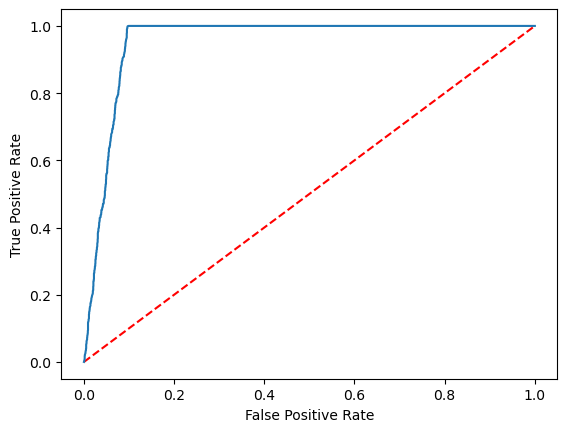

In [22]:
## Plot the ROC curve, no need for pandas as this uses the modelSummary object
modelSummary = lrModel.stages[-1].summary

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(modelSummary.roc.select('FPR').collect(),
         modelSummary.roc.select('TPR').collect())
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [23]:
predictions.select( 'label',  'prediction', 'rawPrediction','probability').show(20)

StatementMeta(NEWPOOL, 3, 23, Finished, Available)

+-----+----------+--------------------+--------------------+
|label|prediction|       rawPrediction|         probability|
+-----+----------+--------------------+--------------------+
|  0.0|       0.0|[1.32590267922033...|[0.93412217565278...|
|  0.0|       0.0|[1.32590267922033...|[0.93412217565278...|
|  0.0|       0.0|[1.32590267922033...|[0.93412217565278...|
|  0.0|       0.0|[1.32590267922033...|[0.93412217565278...|
|  1.0|       1.0|[-1.0473671666611...|[0.10960967056055...|
|  0.0|       0.0|[1.32590267922033...|[0.93412217565278...|
|  0.0|       0.0|[1.32590267922033...|[0.93412217565278...|
|  0.0|       0.0|[1.32590267922033...|[0.93412217565278...|
|  0.0|       0.0|[1.32590267922033...|[0.93412217565278...|
|  0.0|       0.0|[1.32590267922033...|[0.93412217565278...|
|  0.0|       0.0|[1.32590267922033...|[0.93412217565278...|
|  1.0|       1.0|[-1.0161907392465...|[0.11584477645279...|
|  0.0|       1.0|[-1.0473671666611...|[0.10960967056055...|
|  0.0|       0.0|[1.325

In [24]:
print(gbt.explainParams())

StatementMeta(NEWPOOL, 3, 24, Finished, Available)

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

### Task. Calculate the area under the curve and plot the TPR vs FPR graph for one of the models


In [25]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

StatementMeta(NEWPOOL, 3, 25, Finished, Available)

Test Area Under ROC: 0.9635240030809173


StatementMeta(NEWPOOL, 3, 26, Finished, Available)

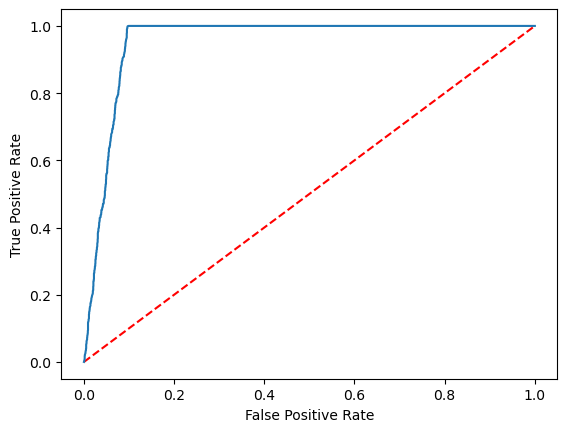

In [26]:
## Plot the ROC curve, no need for pandas as this uses the modelSummary object
modelSummary = lrModel.stages[-1].summary

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(modelSummary.roc.select('FPR').collect(),
         modelSummary.roc.select('TPR').collect())
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

### Show the ground-truth label, prediction and probabilities from the model

In [27]:
predictions.select( 'label',  'prediction', 'rawPrediction','probability').show(20)

StatementMeta(NEWPOOL, 3, 27, Finished, Available)

+-----+----------+--------------------+--------------------+
|label|prediction|       rawPrediction|         probability|
+-----+----------+--------------------+--------------------+
|  0.0|       0.0|[1.32590267922033...|[0.93412217565278...|
|  0.0|       0.0|[1.32590267922033...|[0.93412217565278...|
|  0.0|       0.0|[1.32590267922033...|[0.93412217565278...|
|  0.0|       0.0|[1.32590267922033...|[0.93412217565278...|
|  1.0|       1.0|[-1.0473671666611...|[0.10960967056055...|
|  0.0|       0.0|[1.32590267922033...|[0.93412217565278...|
|  0.0|       0.0|[1.32590267922033...|[0.93412217565278...|
|  0.0|       0.0|[1.32590267922033...|[0.93412217565278...|
|  0.0|       0.0|[1.32590267922033...|[0.93412217565278...|
|  0.0|       0.0|[1.32590267922033...|[0.93412217565278...|
|  0.0|       0.0|[1.32590267922033...|[0.93412217565278...|
|  1.0|       1.0|[-1.0161907392465...|[0.11584477645279...|
|  0.0|       1.0|[-1.0473671666611...|[0.10960967056055...|
|  0.0|       0.0|[1.325